In [4]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
from arviz.plots.plot_utils import xarray_var_iter
import theano
import theano.tensor as tt
from sklearn.preprocessing import PowerTransformer
# import scipy
# import scipy.stats as stats
# import scipy.optimize as opt
# import statsmodels.api as sm
# from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

%matplotlib inline

RANDOM_SEED = 42

In [5]:
print(pm.__version__)

3.8


In [4]:
# from arviz.utils import Numba
# Numba.disable_numba()
# Numba.numba_flag

In [5]:
stockx_data = pd.read_csv('StockX-Data-Contest-2019-3.csv')

In [6]:
#Seeing how many rows/columns we're working with
print(stockx_data.shape)

(99956, 8)


In [7]:
#Getting first glimpse at dataset
stockx_data.head(10)

Order Date   Brand                                   Sneaker Name  \
0     9/1/17   Yeezy           Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1     9/1/17   Yeezy    Adidas-Yeezy-Boost-350-V2-Core-Black-Copper   
2     9/1/17   Yeezy     Adidas-Yeezy-Boost-350-V2-Core-Black-Green   
3     9/1/17   Yeezy       Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4     9/1/17   Yeezy  Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017   
5     9/1/17   Yeezy  Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017   
6     9/1/17   Yeezy     Adidas-Yeezy-Boost-350-V2-Core-Black-White   
7     9/1/17   Yeezy          Adidas-Yeezy-Boost-350-V2-Cream-White   
8     9/1/17   Yeezy          Adidas-Yeezy-Boost-350-V2-Cream-White   
9     9/1/17   Yeezy          Adidas-Yeezy-Boost-350-V2-Cream-White   

  Sale Price Retail Price Release Date  Shoe Size  Buyer Region  
0     $1,097         $220      9/24/16       11.0    California  
1       $685         $220     11/23/16       11.0    California  
2       $690         $220     11/23/16       11.0    California  
3     $1,075         $220     11/23/16       11.5      Kentucky  
4       $828         $220      2/11/17       11.0  Rhode Island  
5       $798         $220      2/11/17        8.5      Michigan  
6       $784         $220     12/17/16       11.0    California  
7       $460         $220      4/29/17       10.0      New York  
8       $465         $220      4/29/17       11.0        Kansas  
9       $465         $220      4/29/17       11.0       Florida

In [8]:
stockx_data.isna().sum()

Order Date      0
Brand           0
Sneaker Name    0
Sale Price      0
Retail Price    0
Release Date    0
Shoe Size       0
Buyer Region    0
dtype: int64

In [9]:
stockx_data.dtypes

Order Date       object
Brand            object
Sneaker Name     object
Sale Price       object
Retail Price     object
Release Date     object
Shoe Size       float64
Buyer Region     object
dtype: object

In [10]:
def cleanCurrency(series):
    """
    Input: a dataframe series for currency (USD)
    Output: cleaned series as a float
    """
    #Replaces dollar sign and comma with empty string
    series = series.str.replace('$', '', regex=True)
    series = series.str.replace(',', '', regex=True)
    series = series.astype(float)
    return series

In [11]:
#Fix the Price fields to only be numeric
stockx_data['Sale Price'] = cleanCurrency(stockx_data['Sale Price'])
stockx_data['Retail Price'] = cleanCurrency(stockx_data['Retail Price'])

#Calculate Profit by subtracting Sale from Retail
stockx_data['Profit'] = stockx_data['Sale Price'] - stockx_data['Retail Price']

In [12]:
#Cleaning Sneaker Name column by removing hyphens
stockx_data['Sneaker Name'] = stockx_data['Sneaker Name'].str.replace('-', '')

#Making brand name a little more descriptive
stockx_data['Brand'] = stockx_data['Brand'].str.replace('Yeezy', 'Yeezy (Adidas)')
stockx_data['Brand'] = stockx_data['Brand'].str.replace('Off-White', 'Off-White (Nike)')

#Getting only 'object' dtype columns and then stripping trailing white spaces
stockx_data_obj = stockx_data.select_dtypes(['object'])
stockx_data[stockx_data_obj.columns] = stockx_data_obj.apply(lambda x: x.str.strip())

In [13]:
#Ensure date fields are the right dtype
stockx_data['Order Date'] = pd.to_datetime(stockx_data['Order Date'])
stockx_data['Release Date'] = pd.to_datetime(stockx_data['Release Date'])

#Calculate Duration of Days from Release Date to Order Date
stockx_data['Duration (days)'] = stockx_data['Order Date'] - stockx_data['Release Date']

In [14]:
#Univariate stats on the numeric measures
stockx_data.describe()

Sale Price  Retail Price     Shoe Size        Profit  \
count  99956.000000   99956.00000  99956.000000  99956.000000   
mean     446.634719     208.61359      9.344181    238.021129   
std      255.982969      25.20001      2.329588    266.133179   
min      186.000000     130.00000      3.500000    -34.000000   
25%      275.000000     220.00000      8.000000     58.000000   
50%      370.000000     220.00000      9.500000    154.000000   
75%      540.000000     220.00000     11.000000    342.000000   
max     4050.000000     250.00000     17.000000   3860.000000   

                   Duration (days)  
count                        99956  
mean   183 days 17:00:33.566769376  
std    232 days 08:29:57.865283340  
min             -69 days +00:00:00  
25%               10 days 00:00:00  
50%               56 days 00:00:00  
75%              345 days 00:00:00  
max             1321 days 00:00:00

In [15]:
print(stockx_data['Order Date'].min(), stockx_data['Order Date'].max())

2017-09-01 00:00:00 2019-02-13 00:00:00


In [16]:
transformer = PowerTransformer()

stockx_data['Profit_transformed'] = transformer.fit_transform(stockx_data['Profit'].values.reshape(-1, 1))

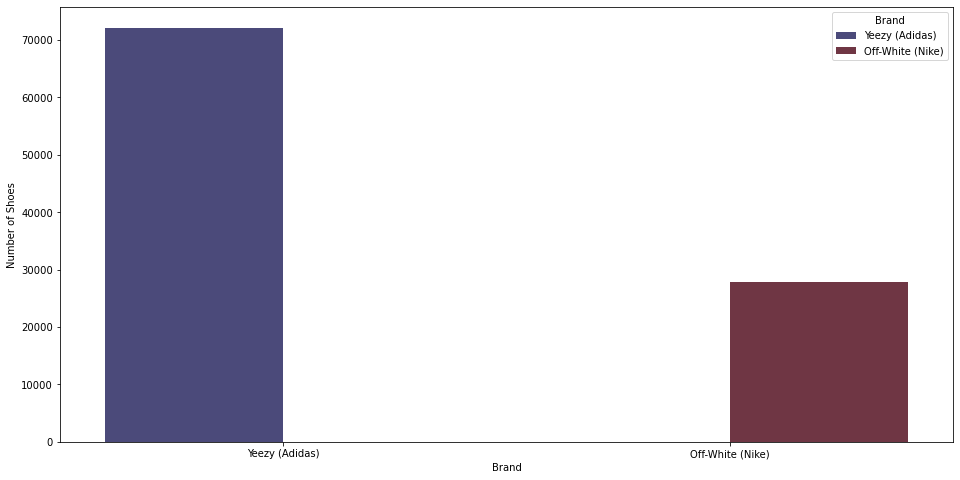

In [17]:
#Grouping by Brand to see how the general distribution of sales are
brand_group = pd.DataFrame(stockx_data.groupby('Brand').size(), columns=['values']).reset_index().sort_values('values', ascending=False)
brand_group['values'] = brand_group['values'].astype(int)
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 10})
ax = sns.barplot(x=brand_group['Brand'], y=brand_group['values'], data=brand_group, hue='Brand', palette="icefire")
ax.set(ylabel='Number of Shoes')
plt.show()

In [18]:
# plt.figure(figsize=(16, 8))
# plt.rcParams.update({'font.size': 10})
# ax = sns.boxplot(x=brand_group['Brand'], y=brand_group['values'], data=brand_group, hue=['Brand'], palette="icefire")
# ax.set(ylabel='Number of Shoes')
# plt.show()

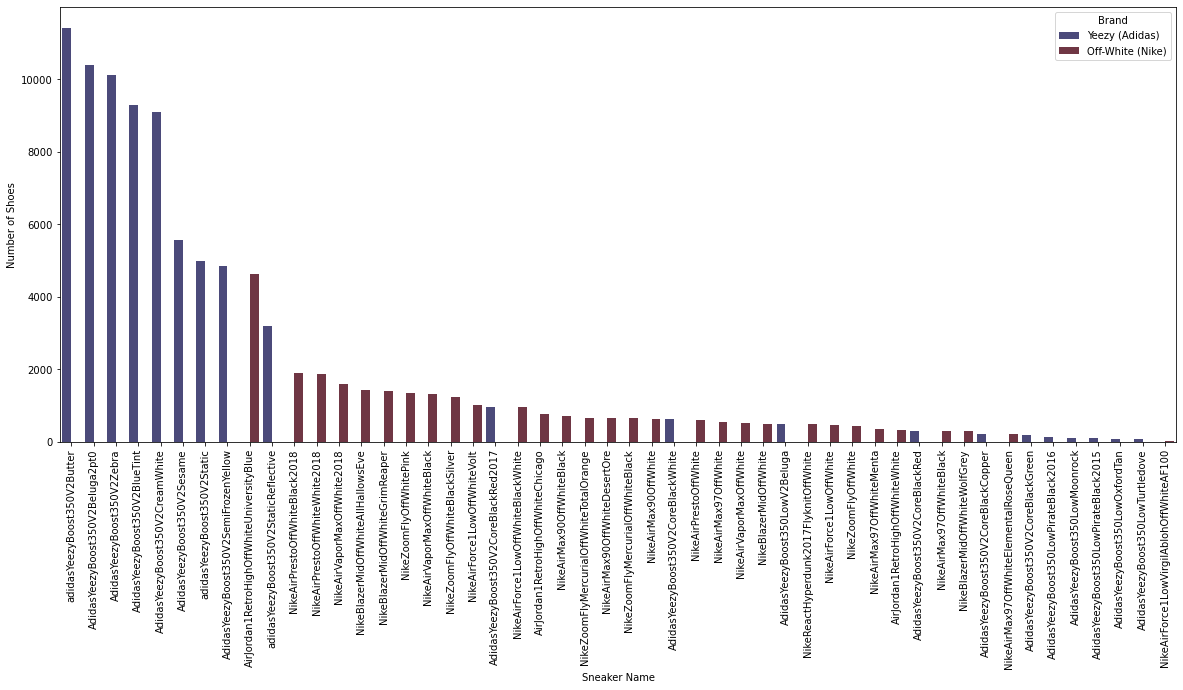

In [19]:
#Grouping by Sneaker Name to see how the general distribution of ratings are
sneaker_group = pd.DataFrame(stockx_data.groupby(['Brand', 'Sneaker Name']).size(), columns=['values']).reset_index().sort_values('values', ascending=False)
sneaker_group['values'] = sneaker_group['values'].astype(int)
plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 10})
ax = sns.barplot(x=sneaker_group['Sneaker Name'], y=sneaker_group['values'], data=sneaker_group, hue='Brand', palette="icefire")
ax.set(ylabel='Number of Shoes')
plt.xticks(rotation=90)
plt.show()

In [20]:
sneaker_group[:10]

Brand                               Sneaker Name  values
47    Yeezy (Adidas)                adidasYeezyBoost350V2Butter   11423
36    Yeezy (Adidas)            AdidasYeezyBoost350V2Beluga2pt0   10395
46    Yeezy (Adidas)                 AdidasYeezyBoost350V2Zebra   10110
37    Yeezy (Adidas)              AdidasYeezyBoost350V2BlueTint    9297
43    Yeezy (Adidas)            AdidasYeezyBoost350V2CreamWhite    9097
45    Yeezy (Adidas)                AdidasYeezyBoost350V2Sesame    5553
48    Yeezy (Adidas)                adidasYeezyBoost350V2Static    4983
44    Yeezy (Adidas)      AdidasYeezyBoost350V2SemiFrozenYellow    4854
1   Off-White (Nike)  AirJordan1RetroHighOffWhiteUniversityBlue    4635
49    Yeezy (Adidas)      adidasYeezyBoost350V2StaticReflective    3184

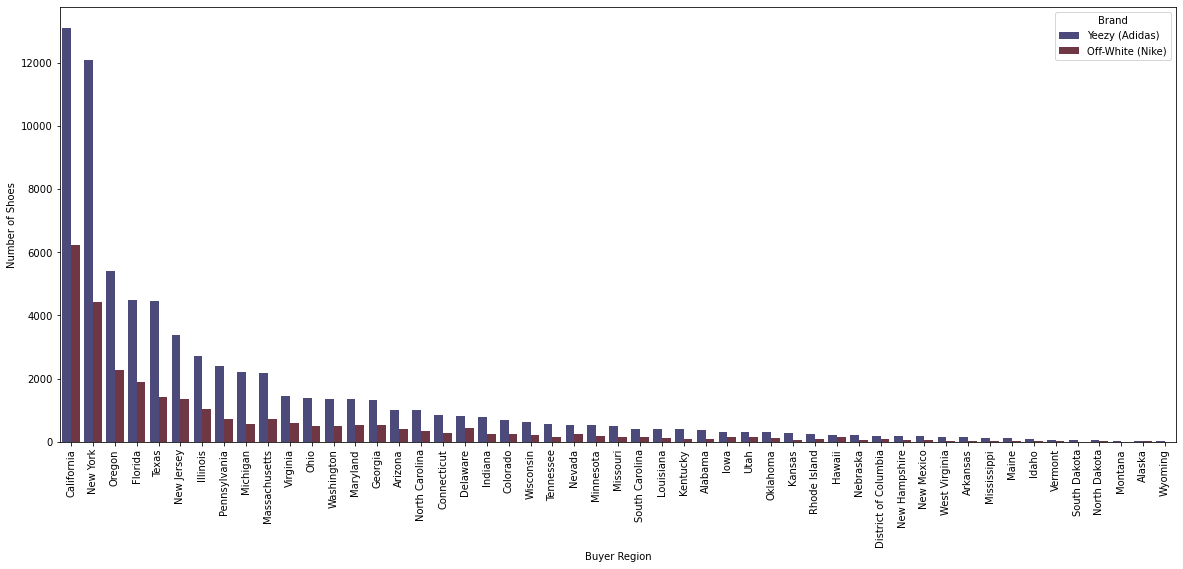

In [21]:
#Grouping by Region to see how the general distribution of ratings are
region_group = pd.DataFrame(stockx_data.groupby(['Buyer Region', 'Brand']).size(), columns=['values']).reset_index().sort_values(by='values', ascending=False)
region_group['values'] = region_group['values'].astype(int)
plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 10})
ax = sns.barplot(x=region_group['Buyer Region'], y=region_group['values'], data=region_group, hue='Brand', palette="icefire")
ax.set(ylabel='Number of Shoes')
plt.xticks(rotation=90)
plt.show()

In [22]:
region_group[:10]

Buyer Region             Brand  values
9     California    Yeezy (Adidas)   13113
65      New York    Yeezy (Adidas)   12103
8     California  Off-White (Nike)    6236
75        Oregon    Yeezy (Adidas)    5396
19       Florida    Yeezy (Adidas)    4484
87         Texas    Yeezy (Adidas)    4455
64      New York  Off-White (Nike)    4422
61    New Jersey    Yeezy (Adidas)    3371
27      Illinois    Yeezy (Adidas)    2732
77  Pennsylvania    Yeezy (Adidas)    2396

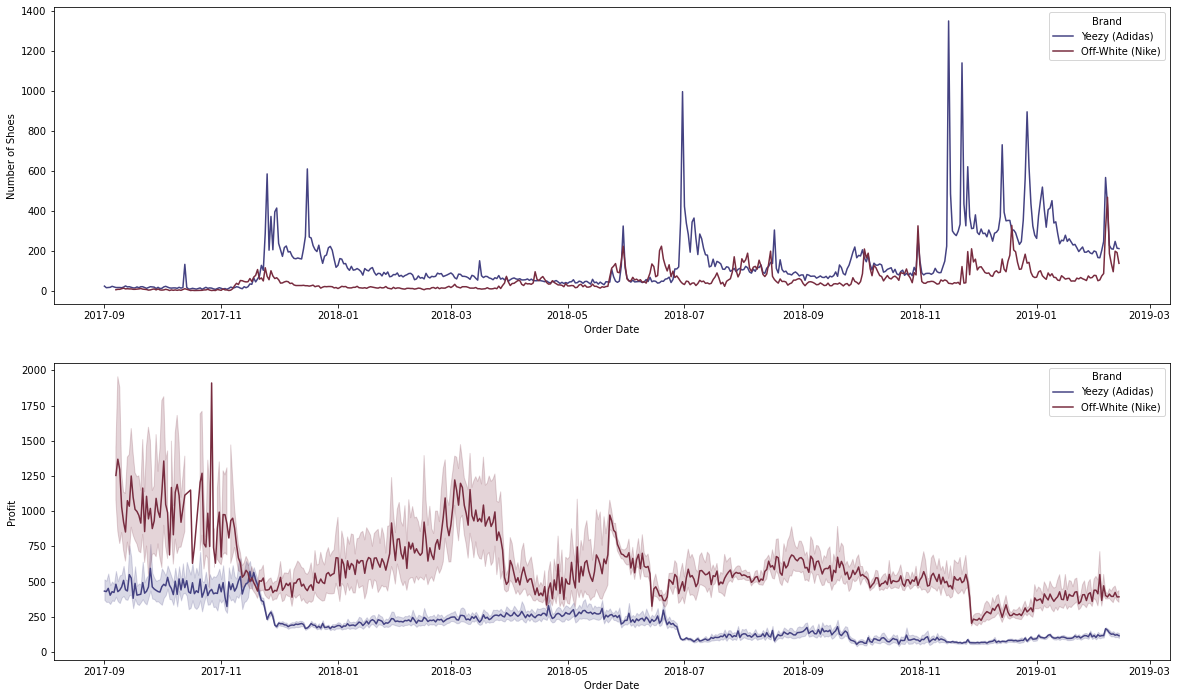

In [23]:
order_group = pd.DataFrame(stockx_data.groupby(['Order Date', 'Brand']).size(), columns=['values']).reset_index().sort_values(by='values', ascending=False)
order_group['values'] = order_group['values'].astype(int)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
plt.rcParams.update({'font.size': 10})
ax1 = sns.lineplot(x=order_group['Order Date'], y=order_group['values'], data=order_group, hue='Brand', palette="icefire", ax=ax1)
ax2 = sns.lineplot(x=stockx_data['Order Date'], y=stockx_data['Profit'], data=stockx_data, hue='Brand', palette="icefire", ax=ax2)
ax1.set(ylabel='Number of Shoes')
plt.show()

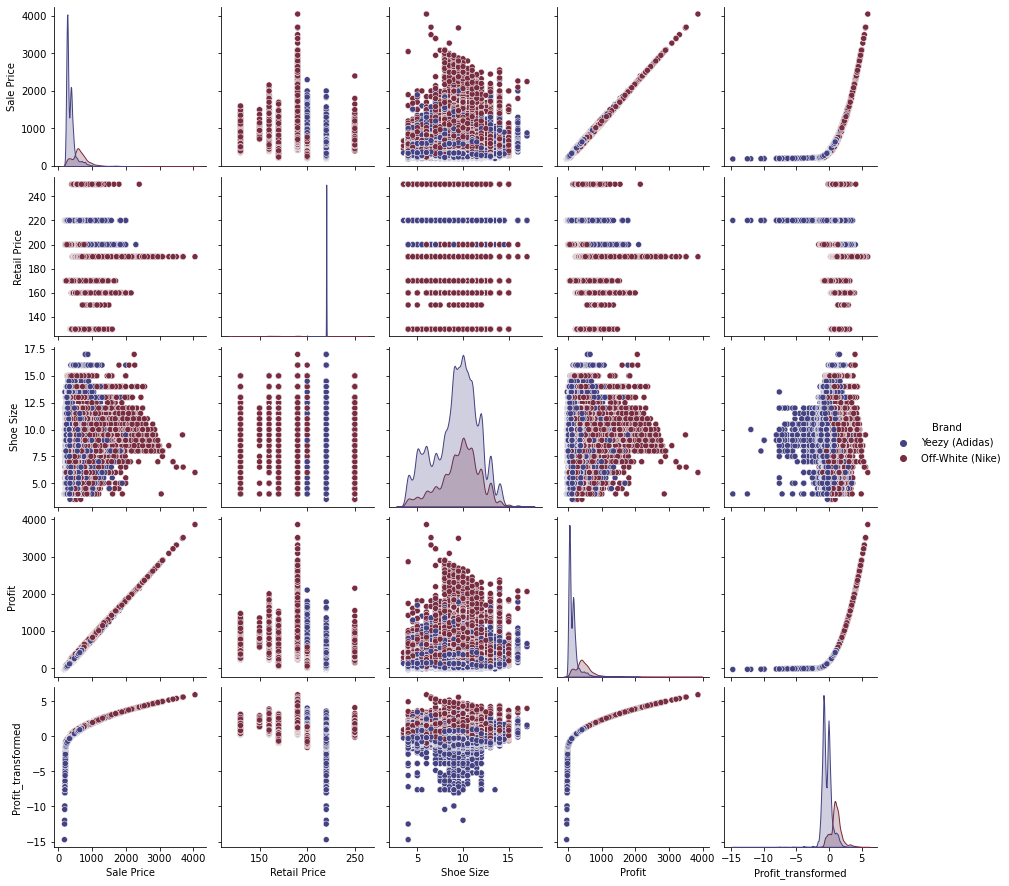

In [24]:
sns.pairplot(stockx_data, diag_kind='kde', hue='Brand', palette='icefire'); 

In [25]:
yeezy = stockx_data[stockx_data['Brand']=='Yeezy (Adidas)']
offwhite = stockx_data[stockx_data['Brand']=='Off-White (Nike)']

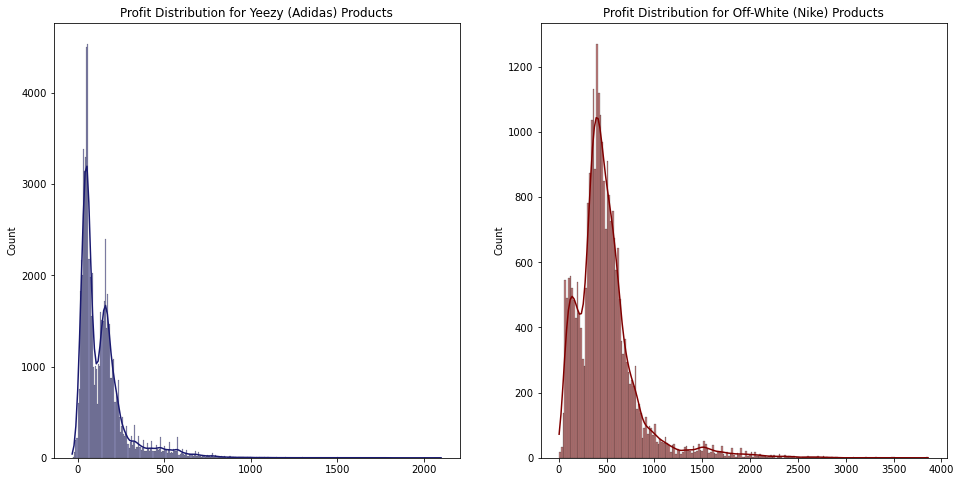

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1 = sns.histplot(yeezy['Profit'].values, kde=True, color='midnightblue', ax=ax1)
ax2 = sns.histplot(offwhite['Profit'].values, kde=True, color='maroon', ax=ax2)

ax1.set_title('Profit Distribution for Yeezy (Adidas) Products')
ax2.set_title('Profit Distribution for Off-White (Nike) Products')

plt.show()

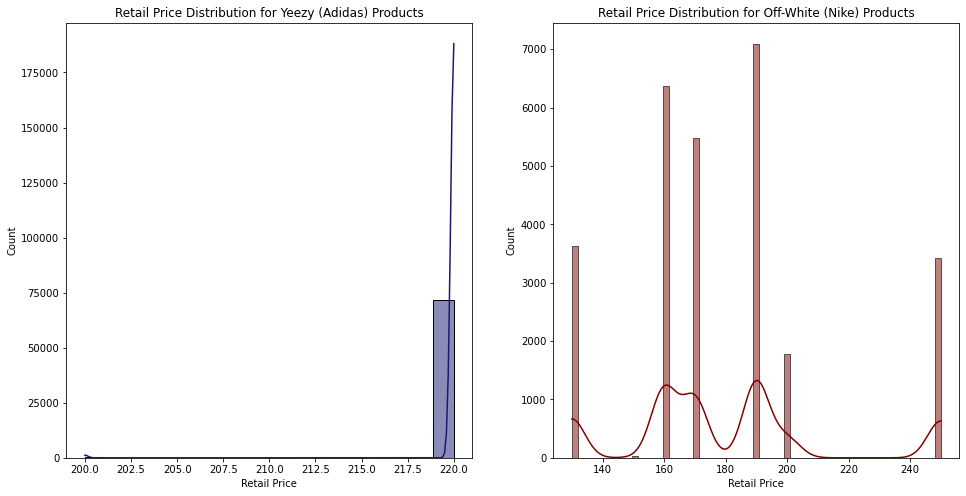

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1 = sns.histplot(yeezy['Retail Price'], kde=True, color='midnightblue', ax=ax1)
ax2 = sns.histplot(offwhite['Retail Price'], kde=True, color='maroon', ax=ax2)

ax1.set_title('Retail Price Distribution for Yeezy (Adidas) Products')
ax2.set_title('Retail Price Distribution for Off-White (Nike) Products')

plt.show()

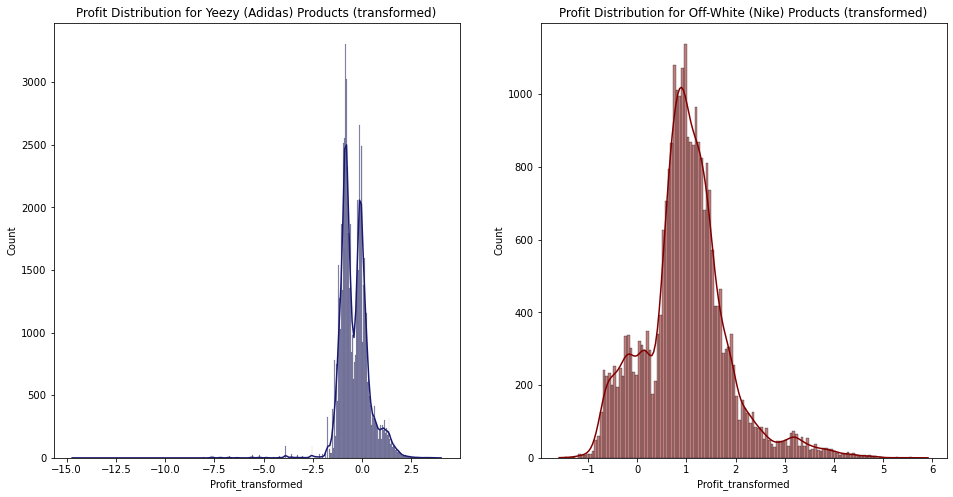

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1 = sns.histplot(yeezy['Profit_transformed'], kde=True, color='midnightblue', ax=ax1)
ax2 = sns.histplot(offwhite['Profit_transformed'], kde=True, color='maroon', ax=ax2)

ax1.set_title('Profit Distribution for Yeezy (Adidas) Products (transformed)')
ax2.set_title('Profit Distribution for Off-White (Nike) Products (transformed)')

plt.show()

In [29]:
yeezy['Profit'].mean(), offwhite['Profit'].mean()

(140.1586569108395, 492.10300784341945)

In [30]:
yeezy['Profit_transformed'].mean(), offwhite['Profit_transformed'].mean()

(-0.3827640780811244, 0.9937764050690868)

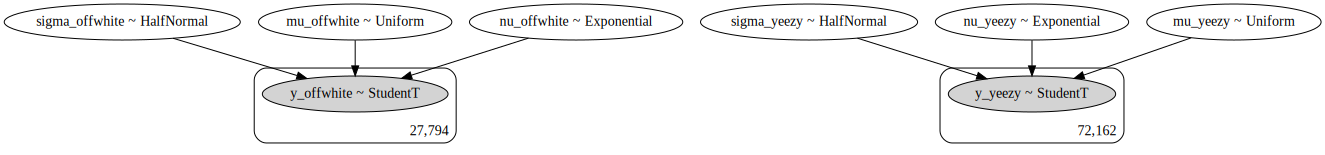

In [31]:
with pm.Model() as model:
    mu_offwhite = pm.Uniform('mu_offwhite', 0, 1000)
    sigma_offwhite = pm.HalfNormal('sigma_offwhite', sd=10)
    nu_offwhite = pm.Exponential('nu_offwhite', 1/30)
    y_offwhite = pm.StudentT('y_offwhite', mu=mu_offwhite, sd=sigma_offwhite, nu=nu_offwhite,
                             observed=offwhite['Profit'])

    mu_yeezy = pm.Uniform('mu_yeezy', 0, 500)
    sigma_yeezy = pm.HalfNormal('sigma_yeezy', sd=10)
    nu_yeezy = pm.Exponential('nu_yeezy', 1/30)
    y_yeezy = pm.StudentT('y_yeezy', mu=mu_yeezy, sd=sigma_yeezy, nu=nu_yeezy,
                        observed=yeezy['Profit'])
    
pm.model_to_graphviz(model)

In [35]:
print(az.__version__)

0.11.0


In [32]:
with model:
    start = pm.find_MAP()
    trace = pm.sample(10000, tune=2000, target_accept=.9, start=start, random_seed=RANDOM_SEED)
#     trace = az.from_pymc3(trace)

TypeError: Unknown parameter type: <class 'pymc3.model.FreeRV'>

In [ ]:
var_names = ['mu_offwhite', 'sigma_offwhite', 'mu_yeezy', 'sigma_yeezy']
lines = list(xarray_var_iter(trace.posterior[var_names].mean(dim=("chain", "draw"))))
az.plot_trace(trace, var_names=var_names, lines=lines);

In [ ]:
lines = list(xarray_var_iter(trace.posterior[['nu_offwhite', 'nu_yeezy']].mean(dim=("chain", "draw"))))
az.plot_trace(trace, var_names=['nu_offwhite', 'nu_yeezy'], lines=lines);

In [ ]:
with model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    idata_prior = az.from_pymc3(prior=prior_checks)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1 = az.plot_dist(idata_prior.prior['mu_yeezy'], kind='kde', rug=True, 
                   quantiles=[.25, .5, .75], color='midnightblue', ax=ax1)
ax2 = az.plot_dist(idata_prior.prior['mu_offwhite'], kind='kde', rug=True,
                   quantiles=[.25, .5, .75], color='maroon', ax=ax2)

ax1.set_title('Prior Distribution for mu_yeezy')
ax2.set_title('Prior Distribution for mu_offwhite')

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1 = az.plot_dist(idata_prior.prior['sigma_yeezy'], kind='kde', rug=True, 
                   quantiles=[.25, .5, .75], color='midnightblue', ax=ax1)
ax2 = az.plot_dist(idata_prior.prior['sigma_offwhite'], kind='kde', rug=True,
                   quantiles=[.25, .5, .75], color='maroon', ax=ax2)

ax1.set_title('Prior Distribution for sigma_yeezy')
ax2.set_title('Prior Distribution for sigma_offwhite')

plt.show()

In [ ]:
az.summary(trace)

In [55]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=var_names+['y_offwhite', 'y_yeezy'], random_seed=RANDOM_SEED)


AttributeError: 'InferenceData' object has no attribute '_straces'

In [50]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.hist([y.mean() for y in ppc['y_yeezy']], bins=19, alpha=0.5, color='midnightblue')
ax2.hist([y.mean() for y in ppc['y_offwhite']], bins=19, alpha=0.5, color='maroon')
ax1.axvline(yeezy['Profit'].mean(), color='r')
ax2.axvline(offwhite['Profit'].mean(), color='r')
for ax in [ax1, ax2]:
    ax.set(xlabel='x', ylabel='')
ax1.set_title('Posterior Predictive Check for y_yeezy')
ax2.set_title('Posterior Predictive Check for y_offwhite');

In [ ]:
yeezy['Profit'].std()

In [ ]:
with model:
    diff_means = pm.Deterministic('means difference', mu_yeezy-mu_offwhite)
    diff_std = pm.Deterministic('stds difference', sigma_yeezy-sigma_offwhite)
    effect_size = pm.Deterministic('effect size (cohens d)', diff_means/np.sqrt((yeezy['Profit'].std() ** 2 + offwhite['Profit'].std() ** 2) / 2))
    

In [ ]:
with model:
    trace = pm.sample(5000, return_inferencedata=True, random_seed=RANDOM_SEED)

In [ ]:
pm.plot_posterior(trace, var_names=['mu_yeezy', 'mu_offwhite', 'sigma_yeezy', 'sigma_offwhite'], color='#87ceeb');

In [ ]:
pm.plot_posterior(trace, var_names=['means difference', 'stds difference', 'effect size (cohens d)'], ref_val=0, color='#87ceeb');

In [ ]:
az.summary(trace, var_names=['means difference', 'stds difference', 'effect size (cohens d)'])

In [ ]:
stockx_data.head()

In [90]:
brand = np.where(stockx_data.Brand=='Off-White (Nike)', 1, 0)
profit_transformed = stockx_data.Profit_transformed
sneakers_unique = stockx_data['Sneaker Name'].unique()
sneakers_count = len(sneakers_unique)
sneaker_lookup = dict(zip(sneakers_unique, range(sneakers_count)))
sneaker = stockx_data['Sneaker Name'].replace(sneaker_lookup).values

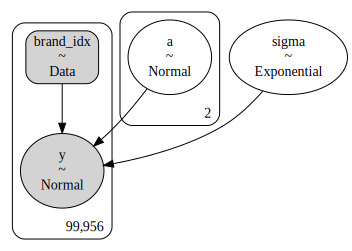

In [65]:
coords = {"Brand": ["Adidas", "Nike"], "obs_id": np.arange(brand.size)}
with pm.Model(coords=coords) as pooled_model:
    brand_idx = pm.Data("brand_idx", brand, dims="obs_id")
    a = pm.Normal("a", 0.0, sigma=10.0, dims="Brand")

    theta = a[brand_idx]
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=profit_transformed, dims="obs_id")

pm.model_to_graphviz(pooled_model)

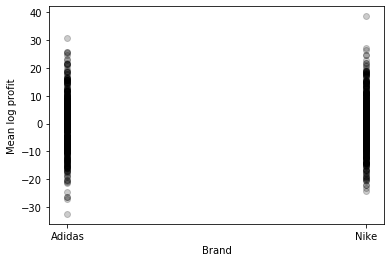

In [66]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    idata_prior = az.from_pymc3(prior=prior_checks)

_, ax = plt.subplots()
idata_prior.prior.plot.scatter(x="Brand", y="a", color="k", alpha=0.2, ax=ax)
ax.set_ylabel("Mean log profit");

In [67]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)
    pooled_idata = az.from_pymc3(pooled_trace)
az.summary(pooled_idata, round_to=2)

/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.


0, dim: obs_id, 99956 =? 99956
0, dim: obs_id, 99956 =? 99956


mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0]  -0.38  0.0   -0.39    -0.38        0.0      0.0   2668.51   1430.91   
a[1]   0.99  0.0    0.98     1.00        0.0      0.0   2247.76   1157.69   
sigma  0.79  0.0    0.78     0.79        0.0      0.0   2313.61   1464.58   

       r_hat  
a[0]     1.0  
a[1]     1.0  
sigma    1.0

/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


0, dim: obs_id, 99956 =? 99956
0, dim: obs_id, 99956 =? 99956


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3bdd054a8>,
      dtype=object)

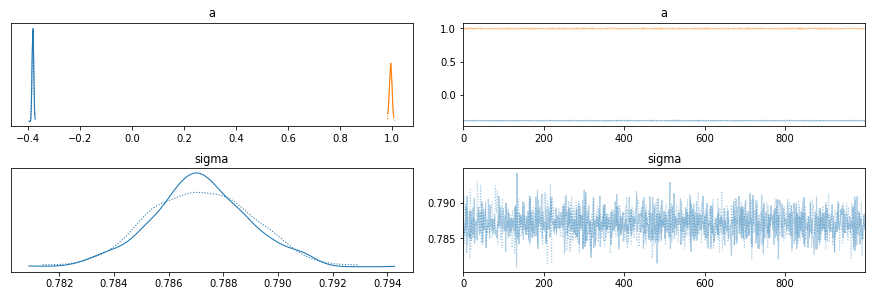

In [68]:
az.plot_trace(pooled_trace)

In [69]:
with pooled_model:
    ppc = pm.sample_posterior_predictive(pooled_trace, random_seed=RANDOM_SEED)
    pooled_idata = az.from_pymc3(pooled_trace, posterior_predictive=ppc, prior=prior_checks)

0, dim: obs_id, 99956 =? 99956


In [70]:
# pooled_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [71]:
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]])
hdi_ppc = (
    pooled_idata.posterior_predictive.y.groupby(pooled_idata.constant_data.brand_idx)
    .apply(hdi_helper)
    .y)
hdi_ppc

<xarray.DataArray 'y' (brand_idx: 2, hdi: 2)>
array([[-1.85999555,  1.10148275],
       [-0.49071637,  2.4706275 ]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * brand_idx  (brand_idx) int64 0 1

In [72]:
brand_labels = pooled_idata.posterior.Brand[pooled_idata.constant_data.brand_idx]
pooled_idata.observed_data = pooled_idata.observed_data.assign_coords(Brand=brand_labels).sortby("Brand")

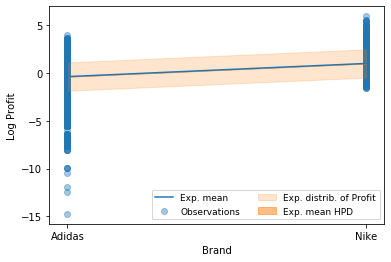

In [73]:
pooled_means = pooled_idata.posterior.mean(dim=("chain", "draw"))

_, ax = plt.subplots()
pooled_idata.observed_data.plot.scatter(x="Brand", y="y", label="Observations", alpha=0.4, ax=ax)

az.plot_hdi(
    [0, 1],
    hdi_data=hdi_ppc,
    fill_kwargs={"alpha": 0.2, "label": "Exp. distrib. of Profit"},
    ax=ax,
)

az.plot_hdi(
    [0, 1], pooled_idata.posterior.a, fill_kwargs={"alpha": 0.5, "label": "Exp. mean HPD"}, ax=ax
)
ax.plot([0, 1], pooled_means.a, label="Exp. mean")

ax.set_ylabel("Log Profit")
ax.legend(ncol=2, fontsize=9, frameon=True);

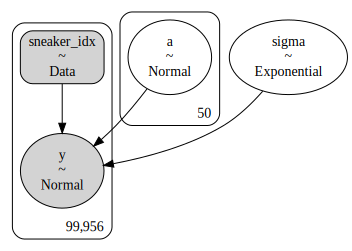

In [94]:
coords["Sneaker"] = sneakers_unique
with pm.Model(coords=coords) as unpooled_model:
#     brand_idx = pm.Data("brand_idx", brand, dims="obs_id")
    sneaker_idx = pm.Data("sneaker_idx", sneaker, dims="obs_id")
    a = pm.Normal("a", 0.0, sigma=10.0, dims="Sneaker")

    theta = a[sneaker_idx]
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=profit_transformed, dims="obs_id")
pm.model_to_graphviz(unpooled_model)

In [92]:
with unpooled_model:
    unpooled_idata = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 847 seconds.


0, dim: obs_id, 99956 =? 99956


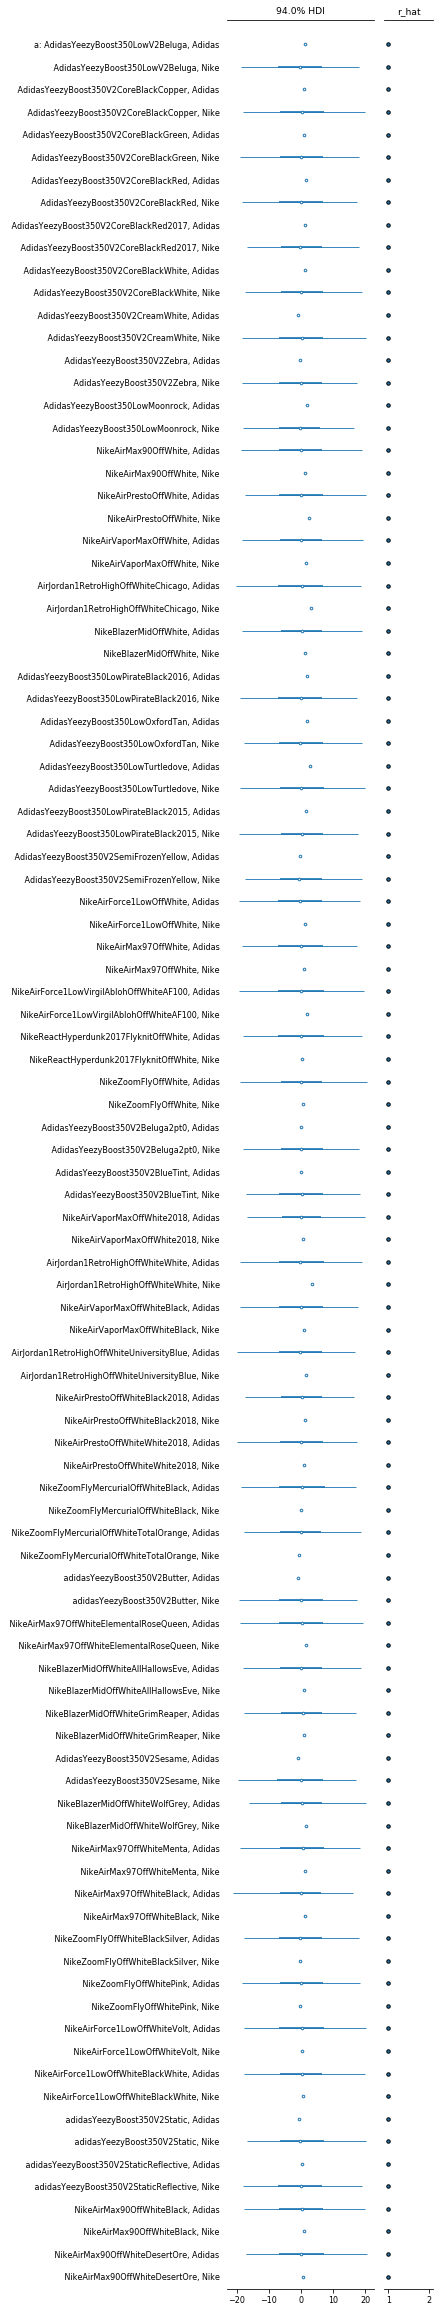

In [93]:
az.plot_forest(unpooled_idata, var_names="a", figsize=(6, 32), r_hat=True, combined=True, textsize=8);

In [87]:
stockx_data[stockx_data['Brand']=='Yeezy (Adidas)']['Sneaker Name'].unique()

array(['AdidasYeezyBoost350LowV2Beluga',
       'AdidasYeezyBoost350V2CoreBlackCopper',
       'AdidasYeezyBoost350V2CoreBlackGreen',
       'AdidasYeezyBoost350V2CoreBlackRed',
       'AdidasYeezyBoost350V2CoreBlackRed2017',
       'AdidasYeezyBoost350V2CoreBlackWhite',
       'AdidasYeezyBoost350V2CreamWhite', 'AdidasYeezyBoost350V2Zebra',
       'AdidasYeezyBoost350LowMoonrock',
       'AdidasYeezyBoost350LowPirateBlack2016',
       'AdidasYeezyBoost350LowOxfordTan',
       'AdidasYeezyBoost350LowTurtledove',
       'AdidasYeezyBoost350LowPirateBlack2015',
       'AdidasYeezyBoost350V2SemiFrozenYellow',
       'AdidasYeezyBoost350V2Beluga2pt0', 'AdidasYeezyBoost350V2BlueTint',
       'adidasYeezyBoost350V2Butter', 'AdidasYeezyBoost350V2Sesame',
       'adidasYeezyBoost350V2Static',
       'adidasYeezyBoost350V2StaticReflective'], dtype=object)

In [80]:
unpooled_means = unpooled_idata.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_idata)

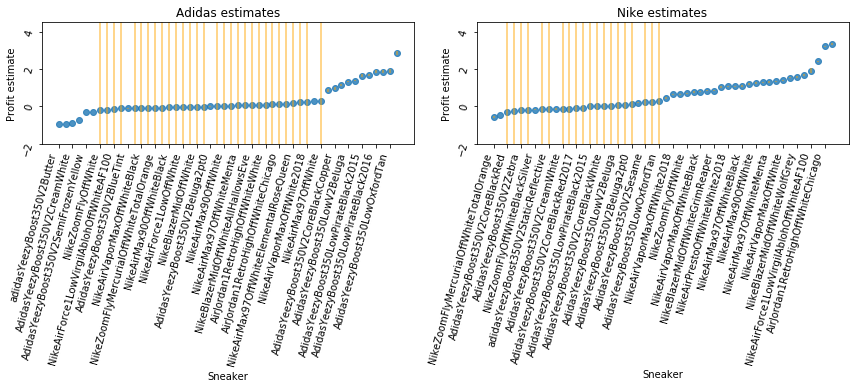

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))
xticks = np.arange(0, 50, 2)
fontdict = {"horizontalalignment": "right", "fontsize": 10}
for ax, brand in zip(axes, ["Adidas", "Nike"]):
    unpooled_means_iter = unpooled_means.sel(Brand=brand).sortby("a")
    unpooled_hdi_iter = unpooled_hdi.sel(Brand=brand).sortby(unpooled_means_iter.a)
    unpooled_means_iter.plot.scatter(x="Sneaker", y="a", ax=ax, alpha=0.8)
    ax.vlines(
        np.arange(sneakers_count),
        unpooled_hdi_iter.a.sel(hdi="lower"),
        unpooled_hdi_iter.a.sel(hdi="higher"),
        color="orange",
        alpha=0.6,
    )
    ax.set(title=f"{brand.title()} estimates", ylabel="Profit estimate", ylim=(-2, 4.5))
    ax.set_xticks(xticks)
    ax.set_xticklabels(unpooled_means_iter.Sneaker.values[xticks], fontdict=fontdict)
    ax.tick_params(rotation=75)
fig.tight_layout();

In [ ]:
with pm.Model(coords=coords) as partial_pooling:
    sneaker_idx = pm.Data("sneaker_idx", sneakers, dims="obs_id")
    # Hyperpriors:
    a = pm.Normal("a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)

    # Varying intercepts:
    a_sneaker = pm.Normal("a_sneaker", mu=a, sigma=sigma_a, dims="Sneaker")

    # Expected value per county:
    theta = a_sneaker[sneaker_idx]
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=profit_transformed, dims="obs_id")
pm.model_to_graphviz(partial_pooling)

In [5]:

nike = adidas_nike['Nike'].values
products = adidas_nike['Product Name'].values
product_len = len(products)
product_lookup = dict(zip(products, range(product_len)))
product = adidas_nike['product code'] = adidas_nike['Product Name'].replace(product_lookup).values

In [7]:
nike = adidas_nike[adidas_nike['Nike'] == 1]['Rating']
adidas = adidas_nike[adidas_nike['Nike'] == 0]['Rating']
nike_rounded = adidas_nike[adidas_nike['Nike'] == 1]['Rounded Rating']
adidas_rounded = adidas_nike[adidas_nike['Nike'] == 0]['Rounded Rating']

nike_rounded_dict = nike_rounded.value_counts().to_dict()
nike_rounded_dict = {k:nike_rounded_dict[k] for k in sorted(nike_rounded_dict)}

adidas_rounded_dict = adidas_rounded.value_counts().to_dict()
adidas_rounded_dict = {k:adidas_rounded_dict[k] for k in sorted(adidas_rounded_dict)}
adidas_rounded_dict

nike_rounded_dict, adidas_rounded_dict

({0: 229, 1: 7, 2: 22, 3: 77, 4: 188, 5: 120},
 {0: 73, 1: 164, 2: 651, 3: 788, 4: 862, 5: 87})

In [11]:
n=6
def multinomial_logprob(n, sign=-1):
    return np.sum(sign*stats.multinomial.logpmf(list(nike_rounded_dict.values()), n=n, p=[1/6]*6))

freq_results = opt.minimize_scalar(multinomial_logprob)
print("The estimated value of mu for nike is: %s" % freq_results['x'])

The estimated value of mu for nike is: 2.6180339603380443


/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:2148: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [12]:
list(nike_rounded_dict.values()), list(adidas_rounded_dict.values())

([229, 7, 22, 77, 188, 120], [73, 164, 651, 788, 862, 87])

In [56]:
alpha = [1,1,1,1,1,1]
y = np.array([list(nike_rounded_dict.values()), list(adidas_rounded_dict.values())])
n = y.sum(axis=1).reshape(-1,1)
n_products, n_stars = y.shape

with pm.Model() as model_shoes:
    theta = pm.Dirichlet("theta", a=np.array([alpha, alpha]), shape=y.shape)
    y = pm.Multinomial("reviews", n=n, p=theta, observed=y)
    

In [62]:
with model_shoes:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    idata_prior = az.from_pymc3(prior=prior_checks)

# _, ax = plt.subplots()
# idata_prior.prior.plot.scatter(x="c", y="theta", color="k", alpha=0.2, ax=ax)
# ax.set_ylabel("Mean Ratings");

In [63]:
with model_shoes:
    trace = pm.sample(draws=3000, tune=1500, random_seed=RANDOM_SEED)
    idata_trace = az.from_pymc3(trace)
    
    
az.summary(idata, round_to=2)

/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_500 tune and 3_000 draw iterations (3_000 + 6_000 draws total) took 40 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0,0]  0.35  0.02    0.32     0.39        0.0      0.0   6005.36   
theta[0,1]  0.01  0.00    0.00     0.02        0.0      0.0   2543.04   
theta[0,2]  0.04  0.01    0.02     0.05        0.0      0.0   3287.32   
theta[0,3]  0.12  0.01    0.10     0.14        0.0      0.0   5614.78   
theta[0,4]  0.29  0.02    0.26     0.33        0.0      0.0   6920.14   
theta[0,5]  0.19  0.02    0.16     0.21        0.0      0.0   3553.93   
theta[1,0]  0.03  0.00    0.02     0.03        0.0      0.0   2670.30   
theta[1,1]  0.06  0.00    0.05     0.07        0.0      0.0   3783.48   
theta[1,2]  0.25  0.01    0.23     0.26        0.0      0.0   6510.81   
theta[1,3]  0.30  0.01    0.28     0.32        0.0      0.0   5601.34   
theta[1,4]  0.33  0.01    0.31     0.34        0.0      0.0   6463.50   
theta[1,5]  0.03  0.00    0.03     0.04        0.0      0.0   6421.01   

            ess_tail  r_hat  
theta[0,0]   4379.08    1.0  
theta[0,1]   2626.08    1.0  
theta[0,2]   3489.79    1.0  
theta[0,3]   3891.74    1.0  
theta[0,4]   4193.01    1.0  
theta[0,5]   4258.94    1.0  
theta[1,0]   3241.29    1.0  
theta[1,1]   3712.10    1.0  
theta[1,2]   4148.87    1.0  
theta[1,3]   4179.65    1.0  
theta[1,4]   4026.47    1.0  
theta[1,5]   4383.03    1.0

/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dd99a1e10>,
      dtype=object)

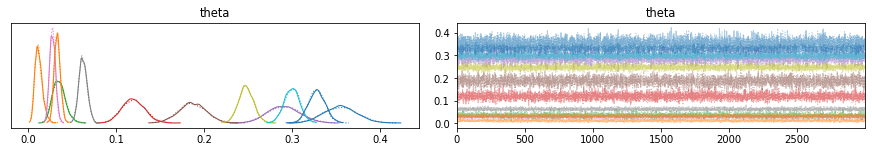

In [72]:
burnin = 100
chain = trace[burnin:]
az.plot_trace(trace)

In [73]:
with model_shoes:
    ppc = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace, posterior_predictive=ppc, prior=prior_checks)

In [74]:
az.summary(idata, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0,0]  0.35  0.02    0.32     0.39        0.0      0.0   6005.36   
theta[0,1]  0.01  0.00    0.00     0.02        0.0      0.0   2543.04   
theta[0,2]  0.04  0.01    0.02     0.05        0.0      0.0   3287.32   
theta[0,3]  0.12  0.01    0.10     0.14        0.0      0.0   5614.78   
theta[0,4]  0.29  0.02    0.26     0.33        0.0      0.0   6920.14   
theta[0,5]  0.19  0.02    0.16     0.21        0.0      0.0   3553.93   
theta[1,0]  0.03  0.00    0.02     0.03        0.0      0.0   2670.30   
theta[1,1]  0.06  0.00    0.05     0.07        0.0      0.0   3783.48   
theta[1,2]  0.25  0.01    0.23     0.26        0.0      0.0   6510.81   
theta[1,3]  0.30  0.01    0.28     0.32        0.0      0.0   5601.34   
theta[1,4]  0.33  0.01    0.31     0.34        0.0      0.0   6463.50   
theta[1,5]  0.03  0.00    0.03     0.04        0.0      0.0   6421.01   

            ess_tail  r_hat  
theta[0,0]   4379.08    1.0  
theta[0,1]   2626.08    1.0  
theta[0,2]   3489.79    1.0  
theta[0,3]   3891.74    1.0  
theta[0,4]   4193.01    1.0  
theta[0,5]   4258.94    1.0  
theta[1,0]   3241.29    1.0  
theta[1,1]   3712.10    1.0  
theta[1,2]   4148.87    1.0  
theta[1,3]   4179.65    1.0  
theta[1,4]   4026.47    1.0  
theta[1,5]   4383.03    1.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dda5204a8>,
      dtype=object)

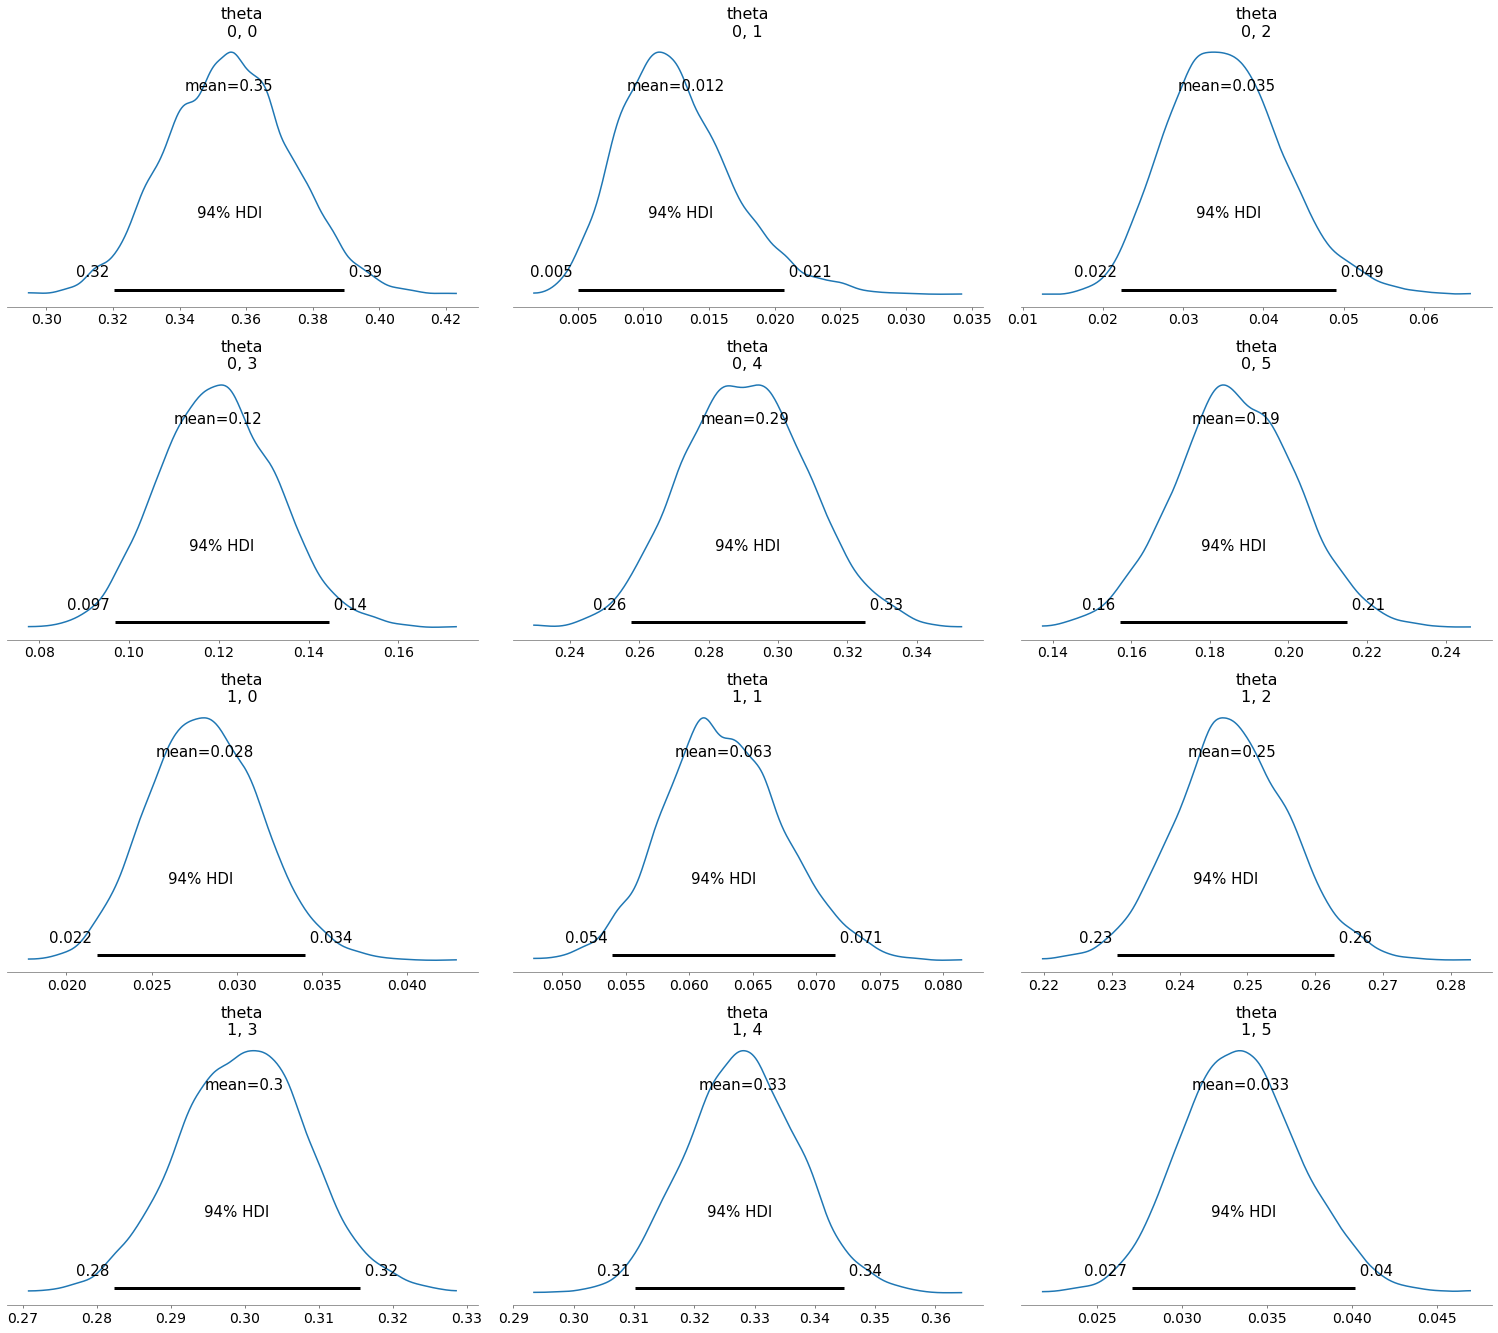

In [78]:
pm.plot_posterior(trace)

In [34]:
with pm.Model() as model_nike:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total)
    
    means = pm.Normal('means', mu=[0.5, 4.5], sd=0.1, shape=clusters)
    sd = pm.HalfCauchy('sd', 0.05)
    
    y = pm.Normal('y', mu=means[category], sd=sd, observed=nike)
    
    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    step2 = pm.Metropolis(vars=[means, sd, p])
    trace_nike = pm.sample(10000, step=[step1, step2], cores=1)

C:\Users\anima\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\anima\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Sequential sampling (2 chains in 1 job)
CompoundStep
>ElemwiseCategorical: [category]
>CompoundStep
>>Metropolis: [p]
>>Metropolis: [sd]
>>Metropolis: [means]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 3993 seconds.
C:\Users\anima\Anaconda3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


C:\Users\anima\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\anima\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015A08BE4688>,
      dtype=object)

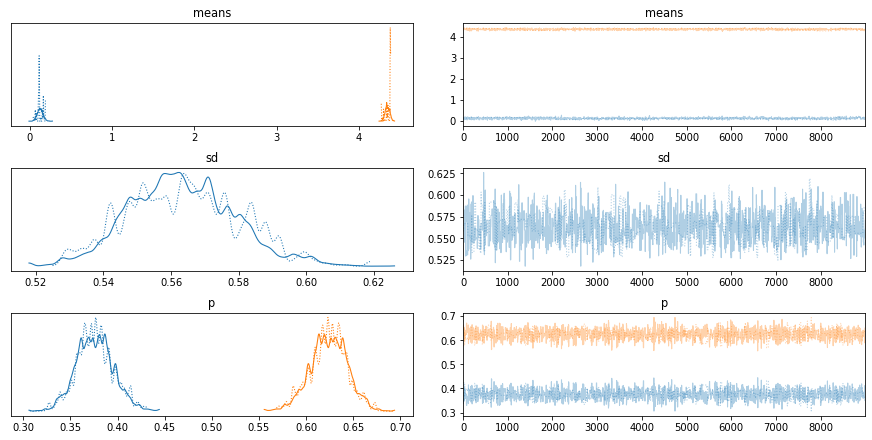

In [35]:
chain_nike = trace_nike[1000:]
varnames_nike = ['means', 'sd', 'p']
pm.traceplot(chain_nike, varnames_nike);

In [37]:
pm.summary(chain_nike, varnames_nike)

C:\Users\anima\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


KeyboardInterrupt: 

In [ ]:
ppc = pm.sample_ppc(chain_nike, 50, model_nike)
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='darkorange')
    
sns.kdeplot(nike, lw=2, color='k')

In [19]:
pop_mu = adidas_nike['Rating'].mean()
pop_std = adidas_nike['Rating'].std() * 2

coords = {"Company": ["Adidas", "Nike"], "obs_id": np.arange(nike.size)}
with pm.Model(coords=coords) as pooled_model:
    nike_idx = pm.Data("nike_idx", nike, dims="obs_id")
    alpha = pm.Normal("alpha", mu=pop_mu, sigma=pop_std, dims="Company")

    theta = alpha[nike_idx]
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=adidas_nike['Rating'].values, dims="obs_id")

# pm.model_to_graphviz(pooled_model)

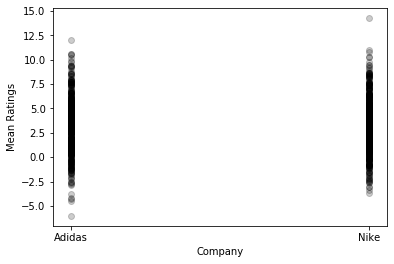

In [20]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    idata_prior = az.from_pymc3(prior=prior_checks)

_, ax = plt.subplots()
idata_prior.prior.plot.scatter(x="Company", y="alpha", color="k", alpha=0.2, ax=ax)
ax.set_ylabel("Mean Ratings");

In [21]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)
    pooled_idata = az.from_pymc3(pooled_trace)
az.summary(pooled_idata, round_to=2)

/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.


0, dim: obs_id, 3268 =? 3268
0, dim: obs_id, 3268 =? 3268


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha[0]  3.37  0.03    3.32     3.42        0.0      0.0   3155.27   1487.84   
alpha[1]  2.73  0.06    2.63     2.84        0.0      0.0   2199.00   1476.60   
sigma     1.41  0.02    1.37     1.44        0.0      0.0   3499.34   1251.64   

          r_hat  
alpha[0]    1.0  
alpha[1]    1.0  
sigma       1.0

/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


0, dim: obs_id, 3268 =? 3268
0, dim: obs_id, 3268 =? 3268


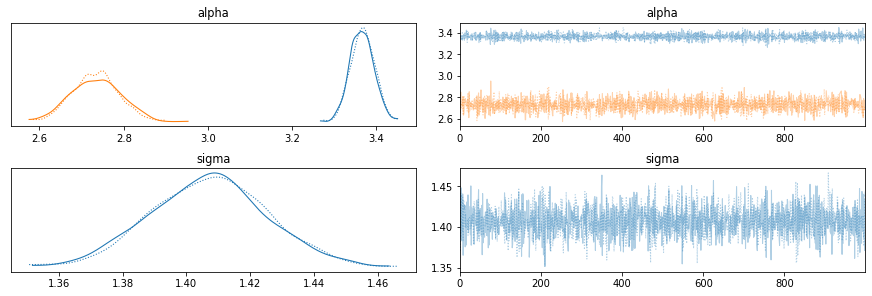

In [23]:
az.plot_trace(pooled_trace);

In [24]:
with pooled_model:
    ppc = pm.sample_posterior_predictive(pooled_trace, random_seed=RANDOM_SEED)
    pooled_idata = az.from_pymc3(pooled_trace, posterior_predictive=ppc, prior=prior_checks)

0, dim: obs_id, 3268 =? 3268


In [25]:
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]])
hdi_ppc = (
    pooled_idata.posterior_predictive.y.groupby(pooled_idata.constant_data.nike_idx)
    .apply(hdi_helper)
    .y
)
hdi_ppc

<xarray.DataArray 'y' (nike_idx: 2, hdi: 2)>
array([[0.72298197, 6.01549965],
       [0.10317841, 5.41006201]])
Coordinates:
  * hdi       (hdi) <U6 'lower' 'higher'
  * nike_idx  (nike_idx) int64 0 1

In [27]:
company_labels = pooled_idata.posterior.Company[pooled_idata.constant_data.nike_idx]
pooled_idata.observed_data = pooled_idata.observed_data.assign_coords(Company=company_labels).sortby(
    "Company"
)

In [31]:
pooled_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

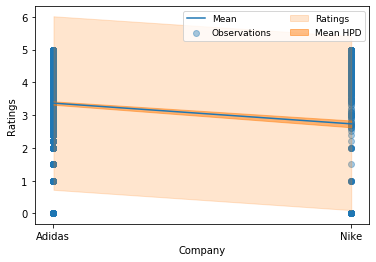

In [30]:
pooled_means = pooled_idata.posterior.mean(dim=("chain", "draw"))

_, ax = plt.subplots()
pooled_idata.observed_data.plot.scatter(x="Company", y="y", label="Observations", alpha=0.4, ax=ax)

az.plot_hdi(
    [0, 1],
    hdi_data=hdi_ppc,
    fill_kwargs={"alpha": 0.2, "label": "Ratings"},
    ax=ax,
)

az.plot_hdi(
    [0, 1], pooled_idata.posterior.alpha, fill_kwargs={"alpha": 0.5, "label": "Mean HPD"}, ax=ax
)
ax.plot([0, 1], pooled_means.alpha, label="Mean")

ax.set_ylabel("Ratings")
ax.legend(ncol=2, fontsize=9, frameon=True);

In [41]:
len(adidas_nike['Product ID'].unique())

3179

In [61]:
with pm.Model(coords=coords) as varying_intercept:
    nike_idx = pm.Data("nike_idx", nike, dims="obs_id")
    product_idx = pm.Data("product_idx", product, dims="obs_id")
    # Hyperpriors:
    alpha = pm.Normal("alpha", mu=0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)

    # Varying intercepts:
    a_product = pm.Normal("a_product", mu=alpha, sigma=sigma_a, dims="Product")
    # Common slope:
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)
    
    # Expected value per product:
    theta = a_product[product_idx] + beta * nike_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    y = pm.Normal("y", theta, sigma=sigma, observed=adidas_nike['Rating'].values, dims="obs_id")
    
# pm.model_to_graphviz(varying_intercept)

In [62]:
with varying_intercept:
    varying_intercept_idata = pm.sample(2000,
                                        tune=2000,
                                        target_accept=.95,
                                        init="adapt_diag", 
                                        random_seed=RANDOM_SEED, 
                                        return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, a_product, sigma_a, alpha]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 232 seconds.


0, dim: obs_id, 3268 =? 3268


The estimated number of effective samples is smaller than 200 for some parameters.


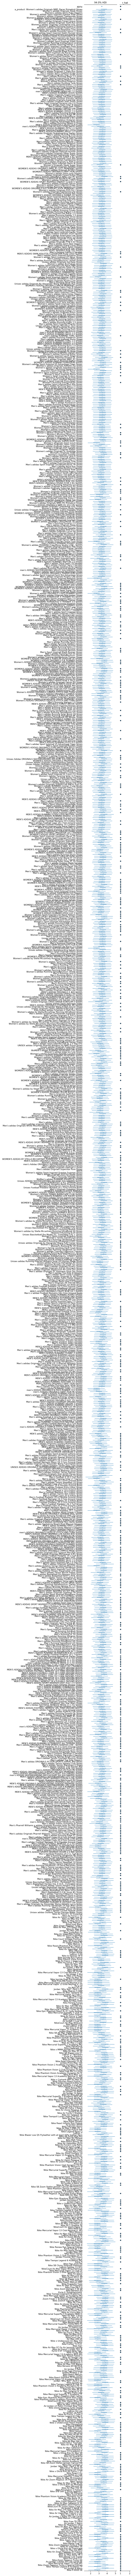

In [64]:
az.plot_forest(varying_intercept_idata, 
               var_names=["alpha", "a_product"], 
               r_hat=True, 
               combined=True, 
               textsize=9);

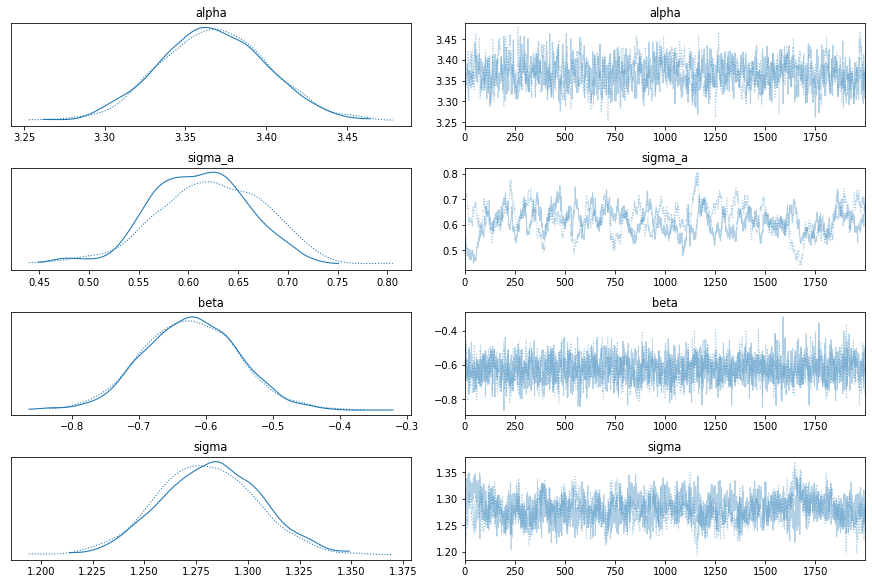

In [65]:
az.plot_trace(varying_intercept_idata, var_names=["alpha", "sigma_a", "beta", "sigma"]);

In [66]:
az.summary(varying_intercept_idata, var_names=["alpha", "sigma_a", "beta", "sigma"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    3.37  0.03    3.31     3.43       0.00     0.00    526.47   1282.73   
sigma_a  0.62  0.05    0.53     0.73       0.01     0.01     56.55    100.25   
beta    -0.62  0.07   -0.76    -0.49       0.00     0.00   1339.85   2435.62   
sigma    1.28  0.02    1.24     1.33       0.00     0.00    161.17    406.53   

         r_hat  
alpha     1.00  
sigma_a   1.02  
beta      1.00  
sigma     1.01

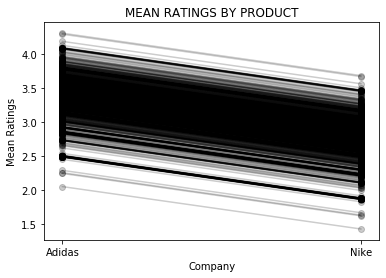

In [70]:
xvals = xr.DataArray([0, 1], dims="Company", coords={"Company": ["Adidas", "Nike"]})
post = varying_intercept_idata.posterior  # alias for readability
theta = ((post.a_product + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean Ratings"))

_, ax = plt.subplots()
theta.plot.scatter(x="Company", y="Mean Ratings", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean Ratings"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN RATINGS BY PRODUCT");

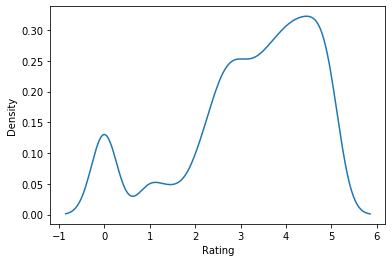

In [40]:
sns.kdeplot(adidas_nike['Rating'])

In [57]:
adidas = adidas_nike[adidas_nike['Brand'].str.contains('Adidas')]
nike = adidas_nike[adidas_nike['Brand'].str.contains('Nike')]

adidas.shape, nike.shape

((2625, 11), (643, 11))

In [45]:
std_low = 1
std_high = 10

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=pop_mu, sd=pop_std)
    group2_mean = pm.Normal('group2_mean', mu=pop_mu, sd=pop_std)
    
    group1_std = pm.Uniform('group1_std', lower=std_low, upper=std_high)
    group2_std = pm.Uniform('group2_std', lower=std_low, upper=std_high)
    
    nu = pm.Exponential('nu', 1/29)+1
    
    lamb1 = group1_std ** 2
    lamb2 = group2_std ** 2
    
    adidas_group = pm.StudentT('adidas', mu=group1_mean, lam=lamb1, nu=nu, 
                         observed=adidas['Rating'].values)
    nike_group = pm.StudentT('nike', mu=group2_mean, lam=lamb2, nu=nu, 
                       observed=nike['Rating'].values)
    
    diff_means = pm.Deterministic('difference of means', group1_mean-group2_mean)
    diff_stds = pm.Deterministic('difference of stds', group1_std-group2_std)
    
    effect_size = pm.Deterministic("effect size", 
                                   diff_means / np.sqrt((group1_std ** 2 + group2_std ** 2) / 2))
    
    trace = pm.sample(2000, return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, group2_std, group1_std, group2_mean, group1_mean]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 26 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc164cafb00>,
      dtype=object)

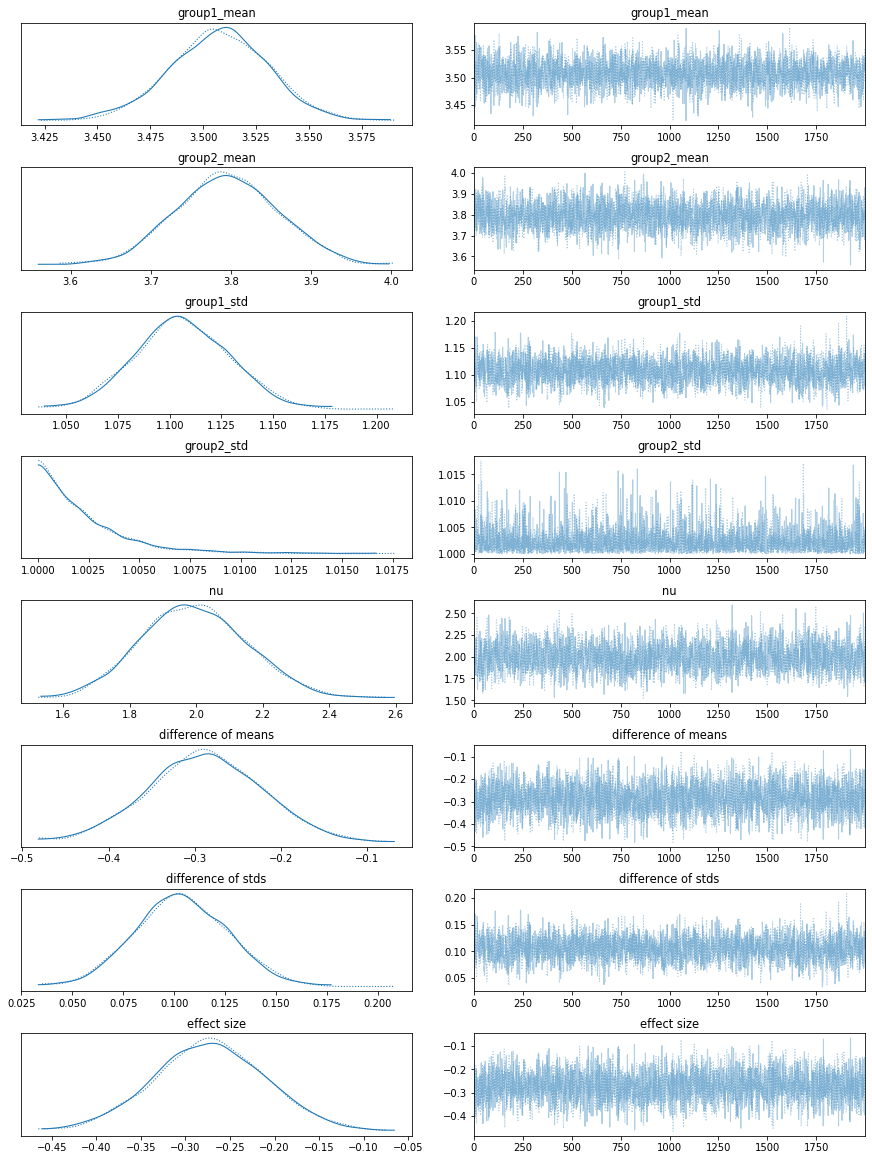

In [53]:
az.plot_trace(trace)

/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """Entry point for launching an IPython kernel.


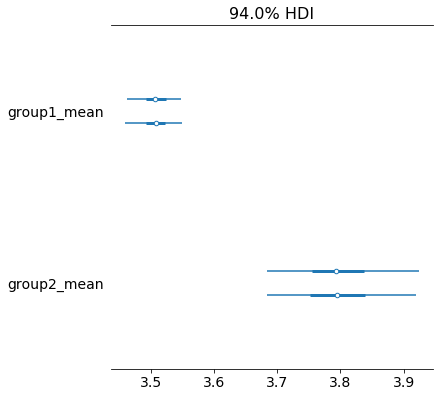

In [50]:
pm.forestplot(trace, var_names=["group1_mean", "group2_mean"]);

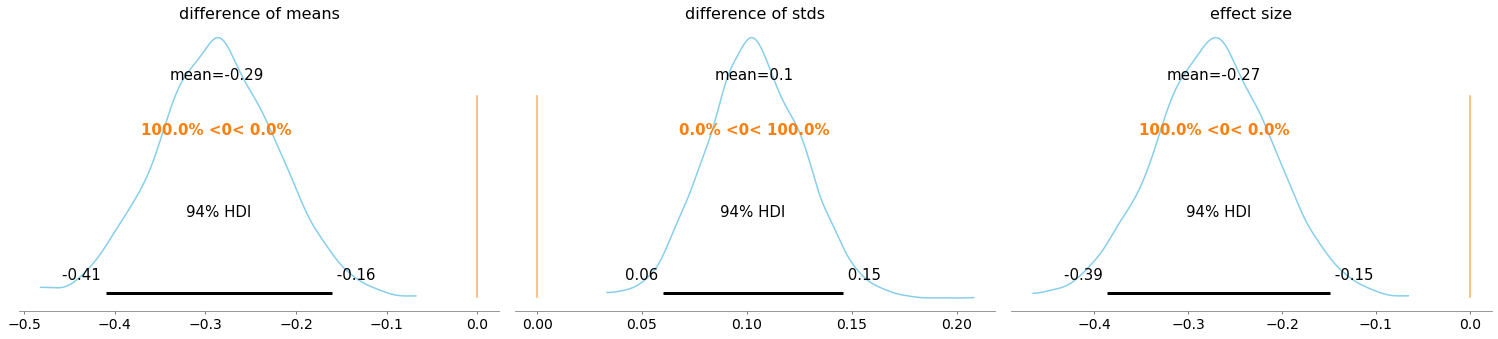

In [47]:
pm.plot_posterior(trace,
                  var_names=["difference of means", "difference of stds", "effect size"],
                  ref_val=0,
                  color="#87ceeb",);

In [52]:
pm.summary(trace, var_names=["difference of means", "difference of stds", "effect size"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
difference of means -0.288  0.067  -0.410   -0.160      0.001    0.001   
difference of stds   0.104  0.023   0.060    0.146      0.000    0.000   
effect size         -0.273  0.063  -0.386   -0.149      0.001    0.001   

                     ess_bulk  ess_tail  r_hat  
difference of means    2924.0    2684.0    1.0  
difference of stds     2438.0    1895.0    1.0  
effect size            2990.0    2682.0    1.0

In [24]:
pm.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     2.736  0.084   2.578    2.891      0.001    0.001    3439.0    2851.0   
sigma  2.142  0.061   2.032    2.263      0.001    0.001    3590.0    2821.0   

       r_hat  
mu       1.0  
sigma    1.0

In [25]:
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/animadurkar/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


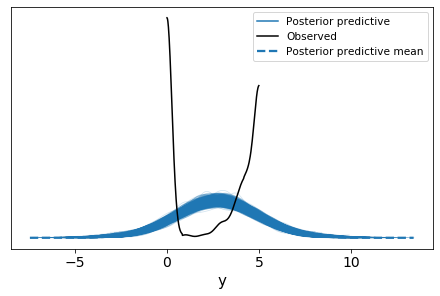

In [26]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));